# Answering Business Question Using SQL
Using chinook.db, a fabricated database of music purchases from an iTunes-store like environment, we'll run various analyses and extract some business insights from the data.
To start, let's import some libraries we'll use later on and define some helper functions.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def run_query(q):
    # opens a connection to database to run a query, q
    # returns a pandas dataframe
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(q):
    # opens a connection to database to run a command with no output
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [4]:
def show_tables():
    # returns a list of all tables and views in our database
    # triple quotes allows us to spread it across several lines for readability
    q = """
            SELECT 
                name, 
                type 
            FROM sqlite_master 
            WHERE type IN (\"table\",\"view\");
        """
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Inventory
First order of business: a hypothetical record label wants us to start marketing and selling some albums in the USA by artists we've never represented before. They've asked us to choose 3 albums out of four available, based on the information below:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

To decide which albums to sell, let's start by finding out which genres have historically sold the most tracks in the USA.

In [6]:
top_usa_genres = """

WITH
    top_USA_genres AS
        (
        SELECT
            g.name AS genre,
            COUNT(t.name) AS tracks
        FROM genre AS g
        INNER JOIN track AS t ON t.genre_id = g.genre_id
        INNER JOIN invoice_line AS il ON il.track_id = t.track_id
        INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id
        INNER JOIN customer AS c ON c.customer_id = i.customer_id
        WHERE c.country = "USA"
        GROUP BY 1
        )   
        
SELECT
    genre,
    tracks AS tracks_sold,
    100.0 * tracks / (SELECT SUM(tracks) from top_USA_genres) AS percent_sold
FROM top_USA_genres
GROUP BY 1
ORDER BY 2 DESC

"""

In [7]:
top_genres = run_query(top_usa_genres)
top_genres.set_index('genre',drop=True,inplace=True)
top_genres

,tracks_sold,percent_sold
genre,,
Rock,561,53.377735
Alternative & Punk,130,12.369172
Metal,124,11.798287
R&B/Soul,53,5.042816
Blues,36,3.425309
Alternative,35,3.330162
Latin,22,2.093245
Pop,22,2.093245
Hip Hop/Rap,20,1.902950


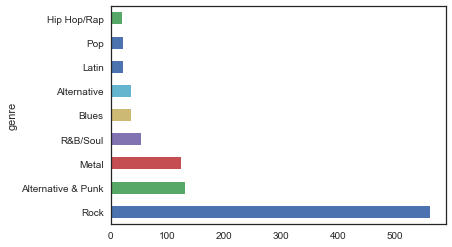

In [23]:
top_genres['tracks_sold'][:9].plot.barh()

Taking what we've found here we can select our top 3 genres to decide which albums to start selling. Based on this analysis, we recommend choosing the punk, blues, and pop albums. That said, it's worth noting that the data barely differentiates between pop and hip-hop, so the choice for our a third album is a bit of a toss-up.
## Employee Performance
Next, let's consider the task of evaluating employee performance and try to determine how much value each of our sales representatives is providing. Let's start by pulling a some data on their sales history.

In [9]:
sales_q = """

WITH
    sales AS
        (
        SELECT
            e.first_name || " " || e.last_name AS name,
            e.hire_date,
            MAX(i.invoice_date) AS most_recent,
            SUM(i.total) AS sales_total
        FROM employee AS e
        INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        GROUP BY 1
        ) 
        
SELECT 
    *,
    (julianday(most_recent) - julianday(hire_date)
    ) / 365 * 12 AS tenure_in_months FROM sales
GROUP BY 1
ORDER BY sales_total DESC

"""

In [10]:
emp_sales = run_query(sales_q)
emp_sales.set_index('name',drop=True,inplace=True)
emp_sales

,hire_date,most_recent,sales_total,tenure_in_months
name,,,,
Jane Peacock,2017-04-01 00:00:00,2020-12-30 00:00:00,1731.51,45.008219
Margaret Park,2017-05-03 00:00:00,2020-12-29 00:00:00,1584.00,43.923288
Steve Johnson,2017-10-17 00:00:00,2020-12-20 00:00:00,1393.92,38.136986


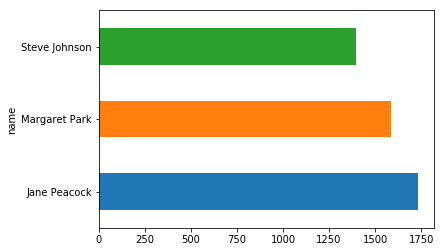

In [11]:
emp_sales['sales_total'].plot.barh()

Well--only three employees, so we're only going to glean so much. But at first glance it would seem that Jane Peacock is really crushing the competition. But if we consider how long each employee has been with the company, it's clear that Jane has got nearly 7 months on our sales-slacker Steve--perhaps we ought to take that into account. Let's go ahead and calculate each of our reps' average sales per month since they started and go from there.

In [12]:
sales_q2 = """

WITH
    sales AS
        (
        SELECT
            e.first_name || " " || e.last_name AS name,
            e.hire_date,
            MAX(i.invoice_date) AS most_recent,
            SUM(i.total) AS sales_total
        FROM employee AS e
        INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        GROUP BY 1
        ),
    sales2 AS
        (
        SELECT 
            *,
            (julianday(most_recent) - julianday(hire_date)
            ) / 365 * 12 AS tenure_in_months 
        FROM sales
        )
SELECT 
    *,
    sales_total / tenure_in_months AS sales_per_month
FROM sales2
ORDER BY sales_per_month DESC

"""

In [13]:
emp_sales2 = run_query(sales_q2)
emp_sales2.set_index('name',drop=True,inplace=True)
emp_sales2

,hire_date,most_recent,sales_total,tenure_in_months,sales_per_month
name,,,,,
Jane Peacock,2017-04-01 00:00:00,2020-12-30 00:00:00,1731.51,45.008219,38.470973
Steve Johnson,2017-10-17 00:00:00,2020-12-20 00:00:00,1393.92,38.136986,36.550345
Margaret Park,2017-05-03 00:00:00,2020-12-29 00:00:00,1584.00,43.923288,36.062874


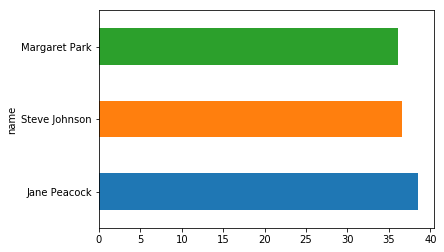

In [14]:
emp_sales2['sales_per_month'].plot.barh()

Seeing these results, it's clear that while Jane is still selling more than her coworkers, the discrepancy is not so stark as it once seemed. To pursue these relationships further we could go into the time series of each of our employees' sales over time to see what other trends we might spot but with so little data to go off right now and monthly sales averages within 5% of each other, I'm more inclined to call this data insignificant for the time being and move on to more interesting questions.
## Sales Data by Country
Next up, let's take a look at sales data for customers from each different country. Note that our dataset has two entries for country, one in the customer table and another in the invoice table for billing country. We'll assume customer profile data is more accurate and work off of the country field from the customer table. All countries with only one customer will be lumped together as "Other."

In [15]:
if 'c_stats' in list(show_tables()['name']):
    run_command("DROP VIEW c_stats;")
    
c = '''
CREATE VIEW c_stats AS
    SELECT
        c.country,
        COUNT(DISTINCT c.customer_id) AS num_customers,
        SUM(i.total) AS total_sales,
        AVG(i.total) AS avg_order_value
    FROM invoice AS i
    INNER JOIN customer AS c ON c.customer_id = i.customer_id 
    GROUP BY 1
    ORDER BY 2 DESC;
'''

run_command(c)

#run_query('SELECT * FROM c_stats')

In [16]:
if 'other_stats' in list(show_tables()['name']):
    run_command("DROP VIEW other_stats;")

d = '''
CREATE VIEW other_stats AS
    SELECT
        CASE WHEN num_customers = 1 THEN "Other"
            ELSE country END AS country,
        num_customers,
        total_sales,
        avg_order_value
    FROM c_stats;
'''

run_command(d)

#run_query('SELECT * FROM other_stats')

In [17]:
q = '''
SELECT 
    country,
    SUM(num_customers) AS customers,
    SUM(total_sales) AS sales,
    SUM(total_sales) / SUM(num_customers) AS avg_sales_per_customer,
    AVG(avg_order_value) AS avg_order_value
FROM (
    SELECT
        o.*,
        CASE
            WHEN o.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM other_stats o
   )
GROUP BY country
ORDER BY sort, sales DESC
'''

sales = run_query(q)
sales.set_index('country',drop=True,inplace=True)
sales

,customers,sales,avg_sales_per_customer,avg_order_value
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


Wasn't that fun? Now, one last thing before we get plotting. That "Other" category that we went to so much work to create? I think it actually obscures the meaning more than helping matters, so let's just go ahead and blow that right off.

In [18]:
sales.drop(index='Other', axis=1, inplace=True)
sales

,customers,sales,avg_sales_per_customer,avg_order_value
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


Perfect. We've got our data, now let's get plotting!

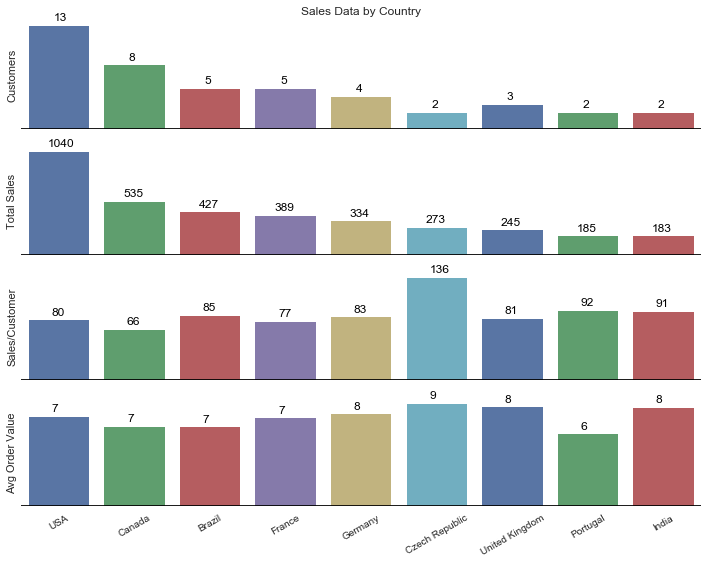

In [19]:
sns.set(style="white", context="notebook")

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(10, 8), sharex=True)
cp = 'deep'

# Generate some sequential data
x = np.array(sales.index)
y1 = sales['customers']
sns.barplot(x=x, y=y1, palette=cp, ax=ax1)
ax1.axhline(0, color="k")
ax1.set_ylabel("Customers")
ax1.set_title('Sales Data by Country')
for i, v in enumerate(y1):
    ax1.text(i -.075, v + max(y1)/20, str(int(v)), color='k')

# Center the data to make it diverging
y2 = sales['sales']
sns.barplot(x=x, y=y2, palette=cp, ax=ax2)
ax2.axhline(0, color="k")
ax2.set_ylabel("Total Sales")
for i, v in enumerate(y2):
    ax2.text(i - .15, v + max(y2)/20, str(int(v)), color='k')
    
# Randomly reorder the data to make it qualitative
y3 = sales['avg_sales_per_customer']
sns.barplot(x=x, y=y3, palette=cp, ax=ax3)
ax3.axhline(0, color="k")
ax3.set_ylabel("Sales/Customer")
for i, v in enumerate(y3):
    ax3.text(i - .1, v + max(y3)/20, str(int(v)), color='k')

# Randomly reorder the data to make it qualitative
y4 = sales['avg_order_value']
sns.barplot(x=x, y=y4, palette=cp, ax=ax4)
ax4.axhline(0, color="k")
ax4.set_ylabel("Avg Order Value")
for i, v in enumerate(y4):
    ax4.text(i - .1, v + max(y4)/20, str(int(v)), color='k')
    
# Finalize the plot
sns.despine(bottom=True, left=True)
plt.setp(f.axes, yticks=[])
plt.xticks(rotation=30)
plt.tight_layout(h_pad=1.5)

For starters, it's clear that we've established ourselves a bit more in the Americas than across the pond. That said, given that our largest market only has 13 customers I'd say that we've got potential for growth literally everywhere! But we can still speculate a bit about where to focus our resources. And based on this data (nevermind that it's a sample size of 2...), the Czech Republic might just be our golden goose. Just look at those sales per customer! Those Czechs are some big spenders. Let's encourage the marketing team to start a campaign over there, and probably consider expansion into Portugal and India as well.
Next up:
## Order Composition: Do customers prefer to buy individual tracks, or entire albums?
Management is considering a new sales strategy. They're wondering if they can reduce overhead by only purchasing popular tracks rather than entire albums. We'll construct a query that categorizes each invoice as either an album purchase or a la carte and report statistics on the number and percentage of invoices that fall under each category. 

In [20]:
order_query = '''
WITH inv AS (
    SELECT 
        il.invoice_id, 
        il.track_id, 
        t.album_id 
    FROM invoice_line il 
    INNER JOIN track t ON il.track_id = t.track_id 
    ), 

alb AS ( 
    SELECT 
        t.album_id, 
        t.track_id 
    FROM track t 
    ) 
    
SELECT 
    inv.invoice_id,
    CASE WHEN (
        SELECT alb.track_id FROM alb 
        WHERE inv.album_id = alb.album_id 
        
        EXCEPT
        
        SELECT il.track_id FROM invoice_line il
        WHERE inv.invoice_id = il.invoice_id 
        ) IS NULL

        AND

        (
        SELECT il.track_id FROM invoice_line il
        WHERE inv.invoice_id = il.invoice_id

        EXCEPT

        SELECT alb.track_id FROM alb
        WHERE inv.album_id = alb.album_id) IS NULL 
    THEN 1
    ELSE 0 
    END AS album_purchase
FROM inv
GROUP BY inv.invoice_id
'''

run_query(order_query)

,invoice_id,album_purchase
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [21]:
order_query = '''
WITH inv AS (
    SELECT 
        il.invoice_id, 
        il.track_id, 
        t.album_id 
    FROM invoice_line il 
    INNER JOIN track t ON il.track_id = t.track_id 
    ), 

alb AS ( 
    SELECT 
        t.album_id, 
        t.track_id 
    FROM track t 
    ), 
    
cat AS (
    SELECT 
        inv.invoice_id,
        CASE WHEN (
            SELECT alb.track_id FROM alb 
            WHERE inv.album_id = alb.album_id 

            EXCEPT

            SELECT il.track_id FROM invoice_line il
            WHERE inv.invoice_id = il.invoice_id 
            ) IS NULL

            AND

            (
            SELECT il.track_id FROM invoice_line il
            WHERE inv.invoice_id = il.invoice_id

            EXCEPT

            SELECT alb.track_id FROM alb
            WHERE inv.album_id = alb.album_id) IS NULL 
        THEN 1
        ELSE 0 
        END AS album_purchase
    FROM inv
    GROUP BY inv.invoice_id
    )
    
SELECT
    COUNT(invoice_id) AS num_invoices,
    100.0 * SUM(album_purchase) / COUNT(invoice_id) AS percent_albums
FROM cat
'''

In [22]:
album_orders = run_query(order_query)
album_orders

,num_invoices,percent_albums
0,614,18.566775


Of the 614 orders in the dataset, just shy of 20% of those orders were for complete albums. Based on that, I would not advise moving to a model of only buying individual tracks.